# NPM Supply Chain Network Analysis
## Automated Analysis Pipeline

This notebook performs a comprehensive analysis of the NPM supply chain network. It executes the following steps:
1.  **Data Acquisition**: Fetches the most dependent packages from `ecosyste.ms`.
2.  **Network Construction**: Builds a dependency graph using `networkx`.
3.  **Risk Assessment**: Calculates centrality metrics and a composite **Behavioral Risk Score (BRS)**.
4.  **Robustness Simulation**: Simulates targeted and random attacks to evaluate network resilience.
5.  **Visualization**: Generates plots for network topology, degree distributions, and simulation results.
6.  **Strategic Insights**: Analyzes risk components and ecosystem relationships.
7.  **Validation**: Validates the BRS model against cascade impact simulations.
8.  **Export**: Saves results for external analysis.

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import sys
import os

# Add current directory to path to ensure imports work
sys.path.append(os.getcwd())

# Import custom modules
from data_loader import get_combined_seed_packages
from network_builder import build_dependency_graph
from metrics import calculate_risk_scores
from simulation import simulate_attacks, calculate_single_node_impact
from utils import export_results
from visualize import (
    plot_network_structure, 
    plot_degree_distributions, 
    plot_correlations, 
    plot_top_risk_scores, 
    plot_simulation_results,
    plot_risk_vs_cascade,
    plot_metric_heatmap, 
    plot_brs_components, 
    plot_ecosystem_vs_network, 
    plot_risk_distribution_by_type,
    plot_brs_vs_cascade_validation, 
    plot_brs_distribution, 
    plot_top20_brs_component_lines
)

# --- Configuration ---
TOP_N = 50              # Number of seed packages to fetch (per category)
MAX_DEPTH = 2           # Traversal depth for the crawler
BETWEENNESS_K = 100     # Sampling size for faster betweenness calculation
API_DELAY = 0.1         # Delay between API calls in seconds
OUTPUT_DIR = '../results'  # Output directory for verification run

# --- Visualization Setup ---
sns.set_theme(style="whitegrid", context="notebook", palette="deep")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.dpi'] = 100

## 2. Data Acquisition
We fetch the top `TOP_N` packages sorted by both **dependents** and **downloads** from the `ecosyste.ms` API. These packages serve as the "seed" nodes for our network crawler.

Using a combined strategy ensures we capture both:
1.  **Infrastructure Giants**: Packages that other packages depend on (High Dependents).
2.  **End-User Tools**: Packages that developers use directly (High Downloads).

In [2]:
# Fetch seed packages (Combined Strategy)
seed_packages = get_combined_seed_packages(limit_dependents=TOP_N, limit_downloads=TOP_N, api_delay=API_DELAY)
print(f"Total unique seed packages: {len(seed_packages)}")

Fetching top 50 packages by DEPENDENTS from ecosyste.ms...


Fetching Dependent Seeds:   0%|          | 0/50 [00:00<?, ?it/s]

Fetching top 50 packages by DOWNLOADS from ecosyste.ms...


Fetching Download Seeds:   0%|          | 0/50 [00:00<?, ?it/s]

Error fetching page 1: 500 Server Error: Internal Server Error for url: https://packages.ecosyste.ms/api/v1/registries/npmjs.org/packages?sort=downloads&per_page=100&page=1. Retrying in 5 seconds...
Error fetching page 1: 500 Server Error: Internal Server Error for url: https://packages.ecosyste.ms/api/v1/registries/npmjs.org/packages?sort=downloads&per_page=100&page=1. Retrying in 5 seconds...
Error fetching page 1: 500 Server Error: Internal Server Error for url: https://packages.ecosyste.ms/api/v1/registries/npmjs.org/packages?sort=downloads&per_page=100&page=1. Retrying in 5 seconds...
Merging lists and removing duplicates...
Total unique seed packages: 97
Total unique seed packages: 97
Merging lists and removing duplicates...
Total unique seed packages: 97
Total unique seed packages: 97


## 3. Network Construction
Using the seed packages, we build a directed dependency graph. The crawler traverses dependencies up to `MAX_DEPTH`.
- **Nodes**: Packages
- **Edges**: Directed dependencies (Package A depends on Package B)


In [3]:
# Build Graph
G = build_dependency_graph(seed_packages, max_depth=MAX_DEPTH, api_delay=API_DELAY)

Starting crawler with 97 seed packages up to depth 2...


Crawling Dependencies: 0it [00:00, ?it/s]

Graph construction complete. Nodes: 560, Edges: 1334


In [4]:
# Print Graph Statistics
print(f"Graph Statistics:")
print(f" - Nodes: {G.number_of_nodes()}")
print(f" - Edges: {G.number_of_edges()}")
print(f" - Density: {nx.density(G):.6f}")
print(f" - Is Strongly Connected: {nx.is_strongly_connected(G)}")
print(f" - Is Weakly Connected: {nx.is_weakly_connected(G)}")


Graph Statistics:
 - Nodes: 560
 - Edges: 1334
 - Density: 0.004261
 - Is Strongly Connected: False
 - Is Weakly Connected: False


## 4. Metrics & Risk Scoring
We calculate centrality metrics to identify critical nodes:
- **In-Degree**: Number of packages depending on a node within the network (Popularity in the backbone).
- **Out-Degree**: Number of dependencies a node has (Complexity and propagation potential).
- **Betweenness Centrality**: Frequency of a node appearing on shortest paths (Bridge/Bottleneck role).
- **Clustering Coefficient**: Local connectivity (Low clustering = Structural Hole/Bridge = High Risk).
- **Dependents Count**: Number of packages depending on this node in the entire NPM ecosystem.
- **Downloads**: Number of downloads (Usage intensity).
- **Staleness**: Days since last update (Abandonware risk).

**Behavioral Risk Score (BRS) Formula (Balanced Model):**

*   **Structure (40%)**: Betweenness (20%) + Clustering (10%) + Out-Degree (10%)
*   **Lifecycle (30%)**: Staleness (20%) + Maintainer Risk (10%)
*   **Popularity (30%)**: In-Degree (10%) + Dependents (10%) + Downloads (10%)

$$BRS = 0.20 \times Betweenness + 0.10 \times Clustering + 0.10 \times OutDegree + 0.20 \times Staleness + 0.10 \times Maintainer + 0.10 \times InDegree + 0.10 \times Dependents + 0.10 \times Downloads$$

All metrics are normalized (0-1) before calculation. Skewed metrics like Downloads and Dependents use log-normalization.

In [5]:
# Calculate Metrics
risk_df = calculate_risk_scores(G, betweenness_k=BETWEENNESS_K)
print("\nTop 10 Critical Packages:")
display(risk_df.head(10))

Calculating network metrics...
Approximating betweenness centrality (k=100)...
Calculating clustering coefficient...

Top 10 Critical Packages:


,package,risk_score,in_degree,out_degree,betweenness,clustering,dependents_count,downloads,staleness_days,maintainer_risk,in_degree_norm,out_degree_norm,betweenness_norm,dependents_count_norm,downloads_norm,staleness_norm,clustering_risk_norm,type,rank
23,@babel/traverse,0.635230,5,7,0.000987,0.068182,4583249,330432404,43,0.25,0.25,0.084337,1.000000,0.985262,0.809230,0.527772,0.931818,seed,24
7,setprototypeof,0.582884,1,0,0.000000,0.000000,5068682,291712487,1257,1.00,0.05,0.000000,0.000000,0.991729,0.796267,0.995420,1.000000,seed,8
72,p-locate,0.581949,1,1,0.000036,0.000000,1089447,755536014,896,1.00,0.05,0.012048,0.036364,0.892970,0.895245,0.948249,1.000000,seed,195
12,fast-deep-equal,0.580252,2,0,0.000000,0.000000,4968905,350162413,897,1.00,0.10,0.000000,0.000000,0.990452,0.815261,0.948404,1.000000,seed,13
219,safer-buffer,0.578789,1,0,0.000000,0.000000,2151694,305880793,1299,1.00,0.05,0.000000,0.000000,0.936689,0.801200,1.000000,1.000000,dependency,108
356,domhandler,0.577246,1,0,0.000000,0.000000,2836242,237217525,1268,1.00,0.05,0.000000,0.000000,0.954433,0.774759,0.996634,1.000000,dependency,80
99,path-parse,0.576917,1,0,0.000000,0.000000,1929330,295947707,1261,1.00,0.05,0.000000,0.000000,0.929682,0.797766,0.995862,1.000000,dependency,132
37,require-directory,0.576431,0,0,0.000000,0.000000,4338986,278669538,1258,1.00,0.00,0.000000,0.000000,0.981744,0.791509,0.995531,1.000000,seed,38
331,retry,0.575809,1,0,0.000000,0.000000,2613336,221969842,1258,1.00,0.05,0.000000,0.000000,0.949175,0.767850,0.995531,1.000000,dependency,85
129,buffer,0.575350,3,2,0.000000,0.050000,1513316,396983609,866,1.00,0.15,0.024096,0.000000,0.914081,0.828314,0.943504,0.950000,dependency,158


## 5. Robustness Simulation
We simulate supply chain attacks by removing nodes and measuring the network's fragmentation.
- **Targeted Attack**: Removing nodes with the highest BRS.
- **Random Attack**: Removing random nodes.
- **Metric**: Size of the Largest Connected Component (LCC). A faster decay in LCC indicates higher vulnerability.

We also calculate the **Cascade Impact** for the top risky nodes, defined as the reduction in LCC size when that single node is removed.


In [6]:
# Run Simulations
print("Running robustness simulations...")
sim_results = simulate_attacks(G, risk_df, num_removals=50)

# Calculate Cascade Impact
print("Calculating cascade impact for top nodes...")
impact_df = calculate_single_node_impact(G, risk_df, sample_size=100)
print("Top 5 Packages by Cascade Impact:")
display(impact_df.head(5))

Running robustness simulations...
Running simulations (Targeted vs Random) for 50 steps...


Targeted Attack:   0%|          | 0/50 [00:00<?, ?it/s]

Random Attack:   0%|          | 0/50 [00:00<?, ?it/s]

Calculating cascade impact for top nodes...
Calculating single-node cascade impact for top 100 nodes...


Impact Analysis:   0%|          | 0/100 [00:00<?, ?it/s]

Top 5 Packages by Cascade Impact:


,package,risk_score,in_degree,out_degree,betweenness,clustering,dependents_count,downloads,staleness_days,maintainer_risk,in_degree_norm,out_degree_norm,betweenness_norm,dependents_count_norm,downloads_norm,staleness_norm,clustering_risk_norm,type,rank,cascade_impact
23,@babel/traverse,0.635230,5,7,0.000987,0.068182,4583249,330432404,43,0.25,0.25,0.084337,1.000000,0.985262,0.809230,0.527772,0.931818,seed,24,1
7,setprototypeof,0.582884,1,0,0.000000,0.000000,5068682,291712487,1257,1.00,0.05,0.000000,0.000000,0.991729,0.796267,0.995420,1.000000,seed,8,1
72,p-locate,0.581949,1,1,0.000036,0.000000,1089447,755536014,896,1.00,0.05,0.012048,0.036364,0.892970,0.895245,0.948249,1.000000,seed,195,0
12,fast-deep-equal,0.580252,2,0,0.000000,0.000000,4968905,350162413,897,1.00,0.10,0.000000,0.000000,0.990452,0.815261,0.948404,1.000000,seed,13,5
219,safer-buffer,0.578789,1,0,0.000000,0.000000,2151694,305880793,1299,1.00,0.05,0.000000,0.000000,0.936689,0.801200,1.000000,1.000000,dependency,108,1


## 6. Core Network Metrics
Here we visualize the fundamental structure of the network and the distribution of node degrees.
- **Network Topology**: A visual representation of the graph (sampled if too large).
- **Degree Distributions**: Histograms showing In-Degree and Out-Degree distributions (typically power-law).
- **Correlations**: A scatter matrix showing relationships between different risk metrics.
- **Top Risk Scores**: A bar chart of the packages with the highest BRS.

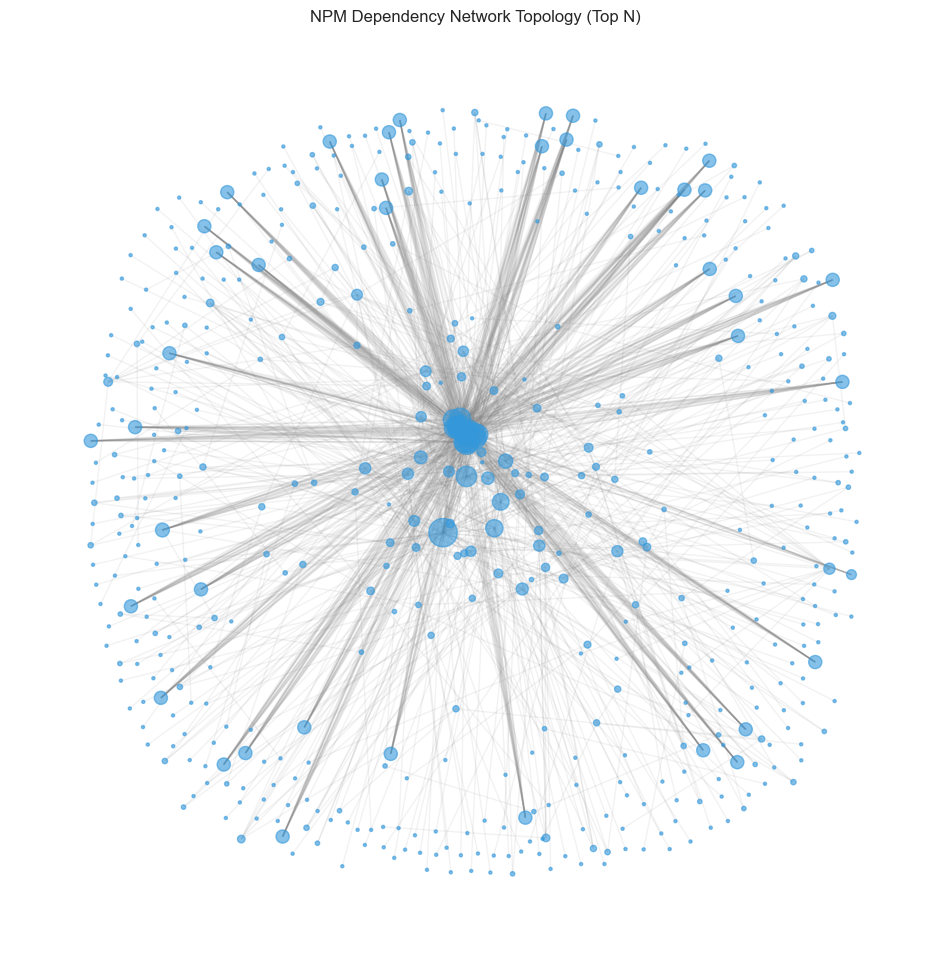

 - Saved ../results_verification/plots/network_full_topN.png


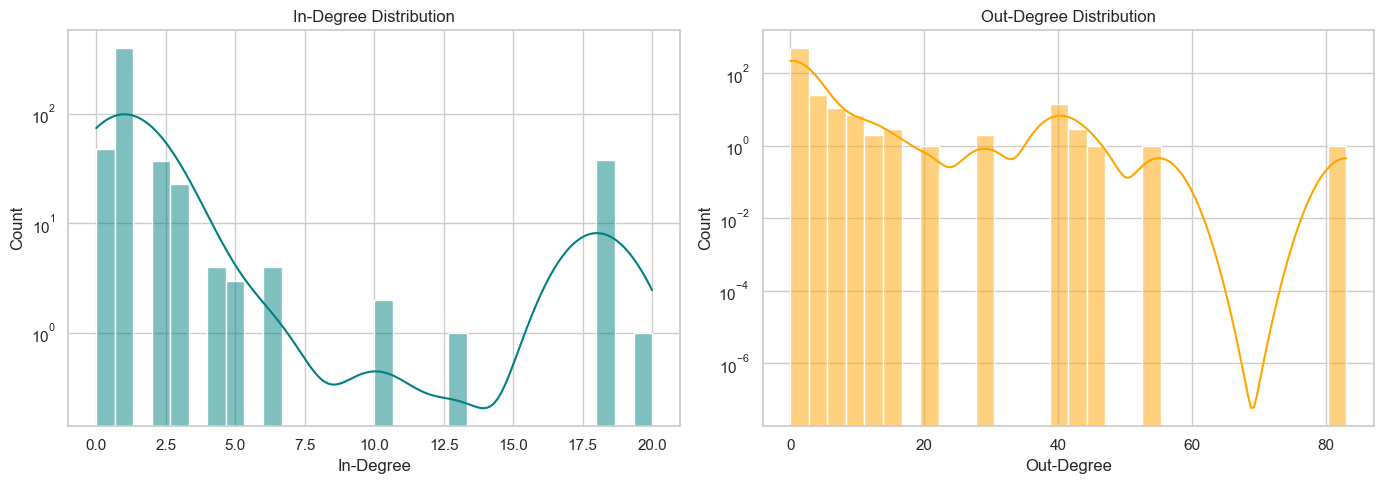

 - Saved ../results_verification/plots/degree_histograms.png


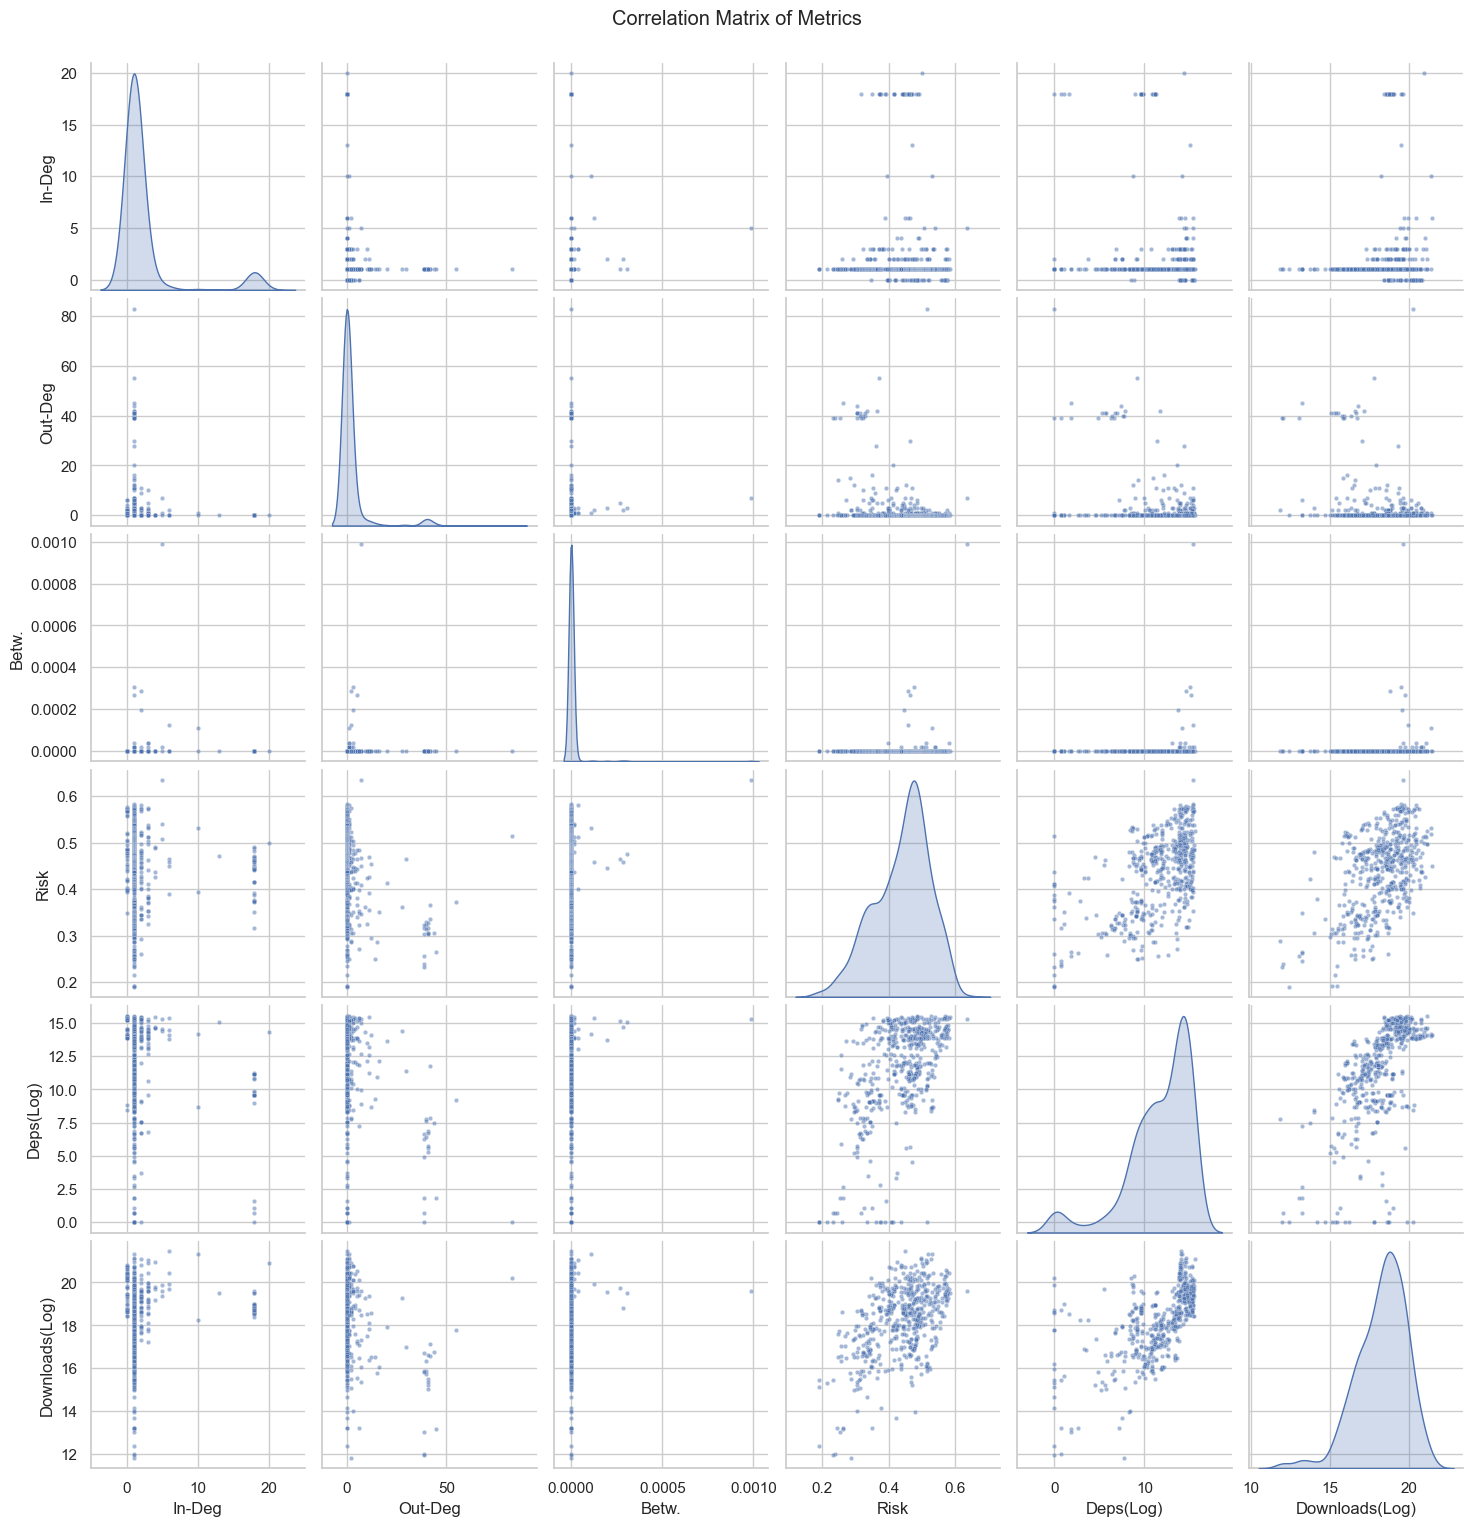

 - Saved ../results_verification/plots/scatter_correlations.png


c:\Users\WORKSTATION\Documents\GitHub\npm-supply-chain-network-analysis\analysis\visualize.py:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='risk_score', y='package', data=top_df, palette='viridis')


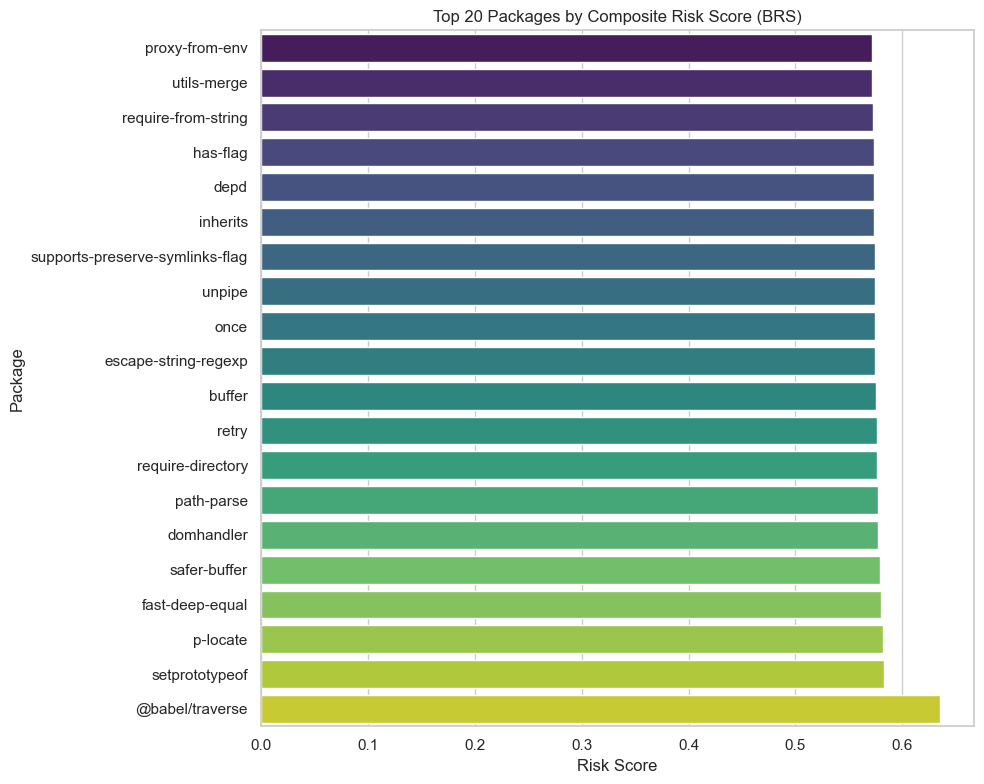

 - Saved ../results_verification/plots/top20_risk_scores.png


In [7]:
# 1. Network Topology
plot_network_structure(G, output_dir=OUTPUT_DIR + '/plots')

# 2. Degree Distributions
plot_degree_distributions(G, output_dir=OUTPUT_DIR + '/plots')

# 3. Correlations (Metrics)
plot_correlations(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 4. Top Risk Scores
plot_top_risk_scores(risk_df, output_dir=OUTPUT_DIR + '/plots')

## 7. Robustness & Cascade Analysis
This section focuses on the network's resilience to attacks.
- **Risk vs Cascade Impact**: Scatter plot showing if high-risk nodes actually cause high damage when removed.
- **Simulation Results**: Line chart comparing network degradation (LCC size) under Targeted vs Random attacks.

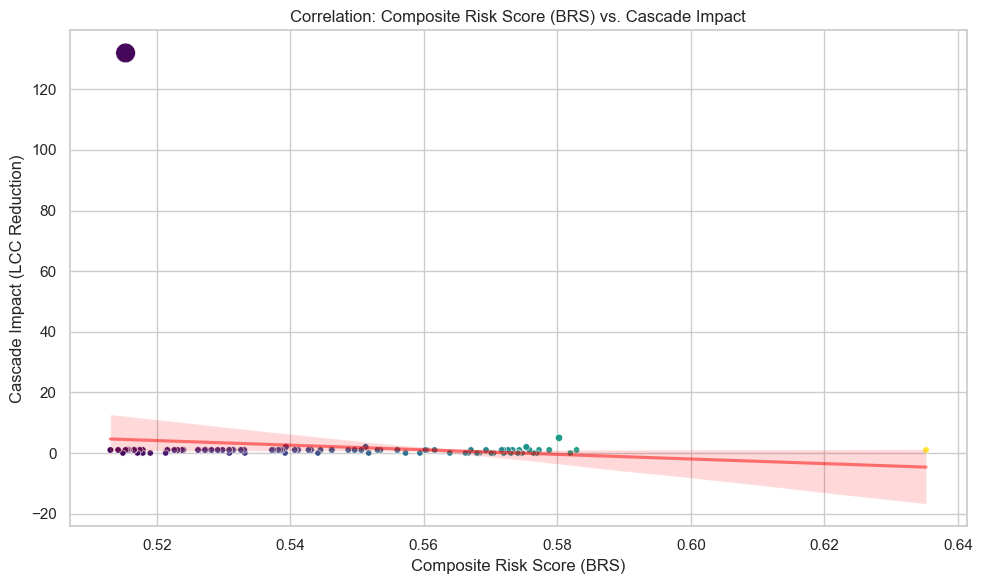

 - Saved ../results_verification/plots/risk_vs_cascade.png


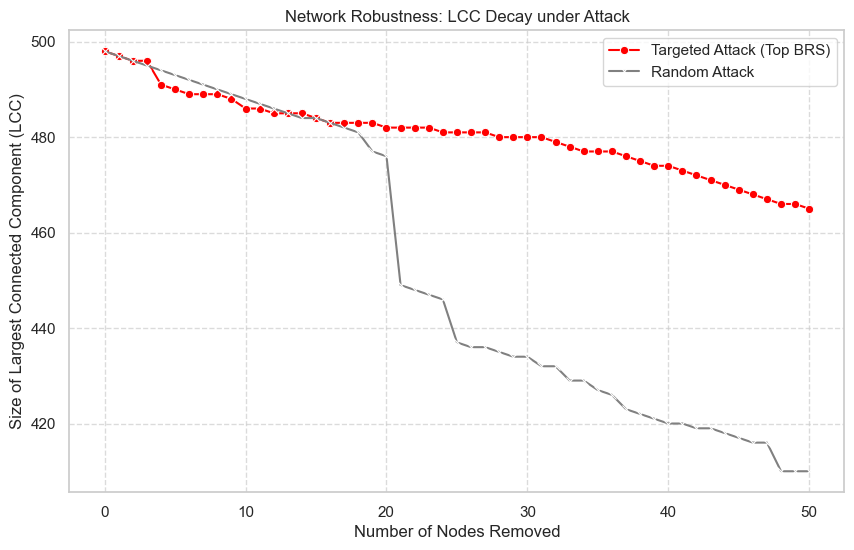

 - Saved ../results_verification/plots/top20_cascade_impact.png


In [8]:
# 5. Risk vs Cascade Impact Correlation
plot_risk_vs_cascade(impact_df, output_dir=OUTPUT_DIR + '/plots')

# 6. Simulation Results (Robustness)
plot_simulation_results(sim_results, output_dir=OUTPUT_DIR + '/plots')

## 8. Strategic Insights
Advanced visualizations to understand the multidimensional nature of supply chain risk.
- **Multi-metric Heatmap**: Visualizes how top packages score across different metrics (Popularity, Structure, Lifecycle).
- **BRS Components**: Stacked bar chart showing which factors contribute most to the risk score of critical packages.
- **Ecosystem vs Network**: Compares a package's global popularity (NPM dependents) vs its structural centrality in our graph.
- **Risk Distribution by Type**: Shows if "discovered" packages (found via crawling) are as risky as the initial "seed" packages.

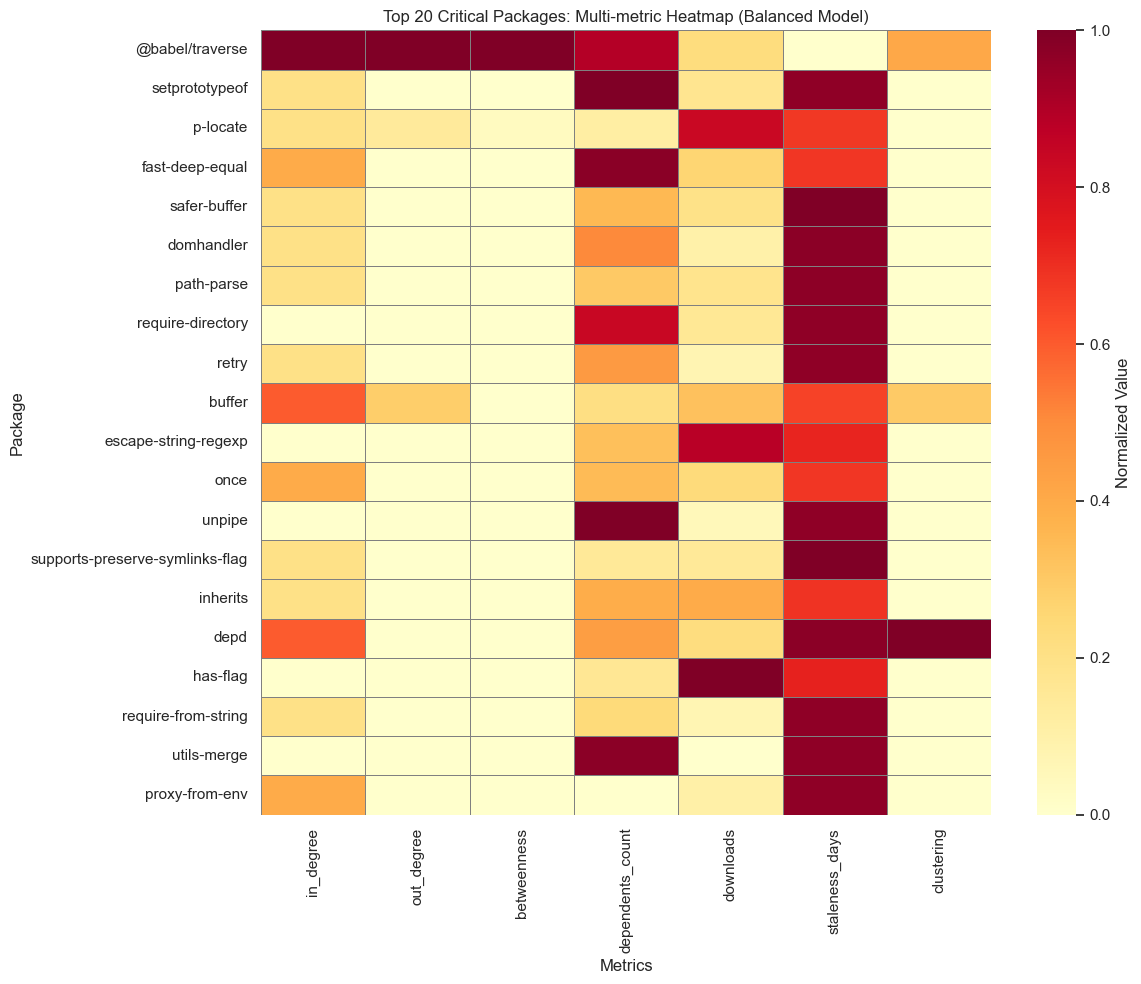

 - Saved ../results_verification/plots/metric_heatmap_top20.png


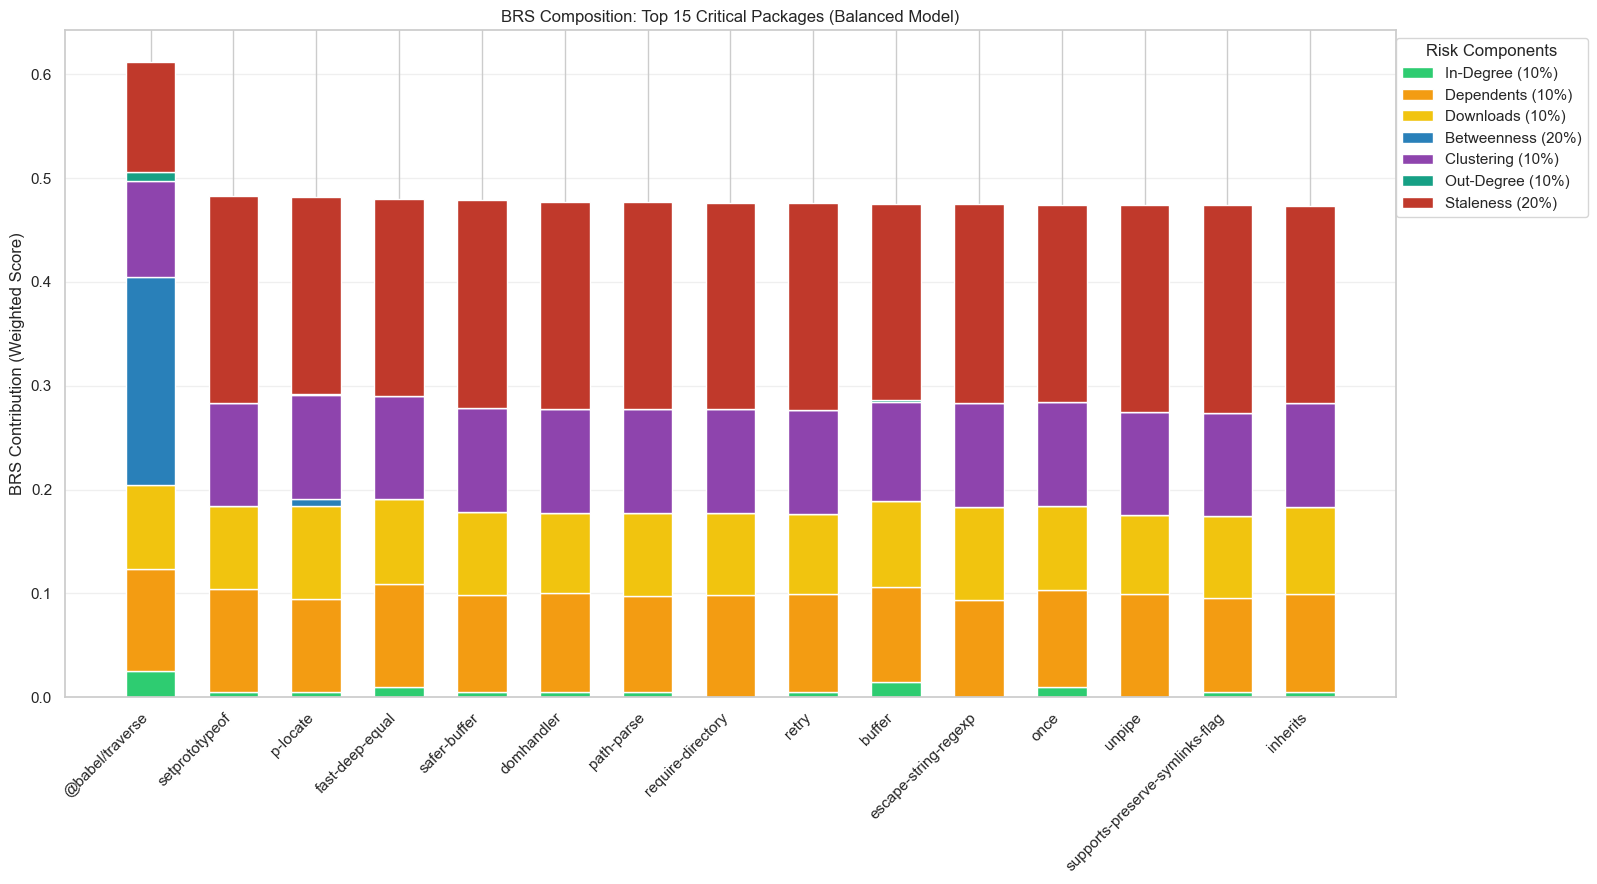

 - Saved ../results_verification/plots/brs_components_breakdown.png


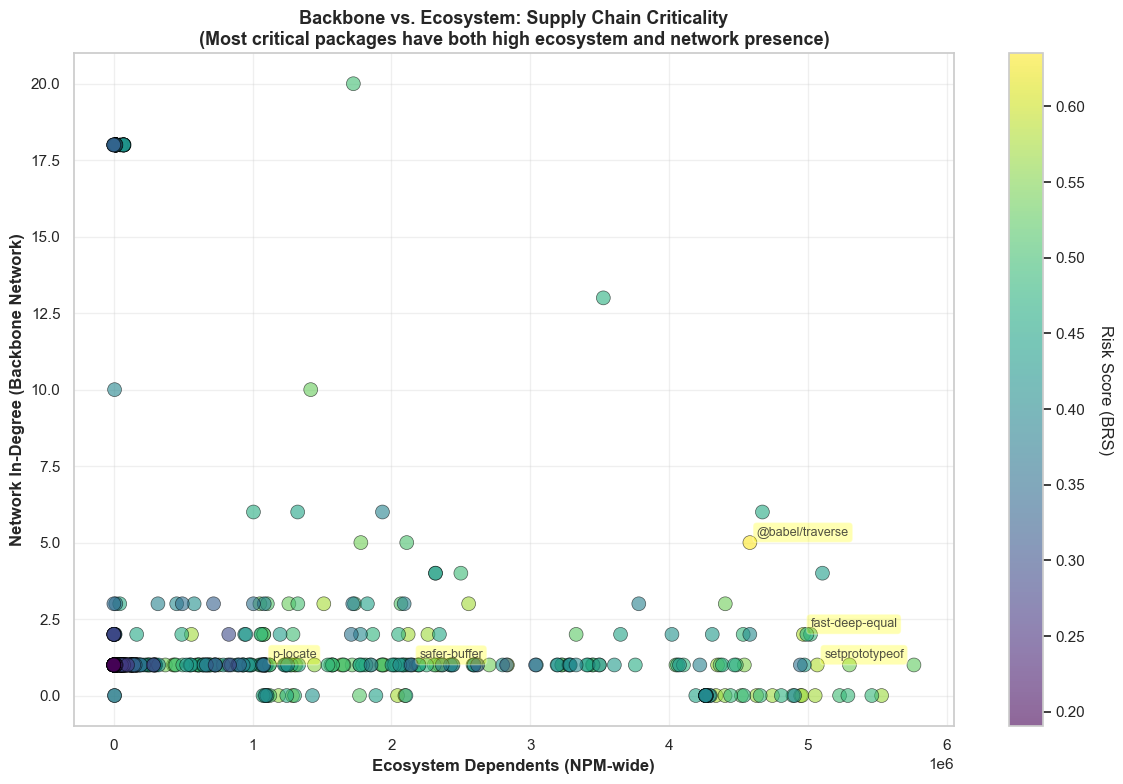

 - Saved ../results_verification/plots/ecosystem_vs_network.png


c:\Users\WORKSTATION\Documents\GitHub\npm-supply-chain-network-analysis\analysis\visualize.py:326: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=risk_df, x='type', y='risk_score', palette='Set2')


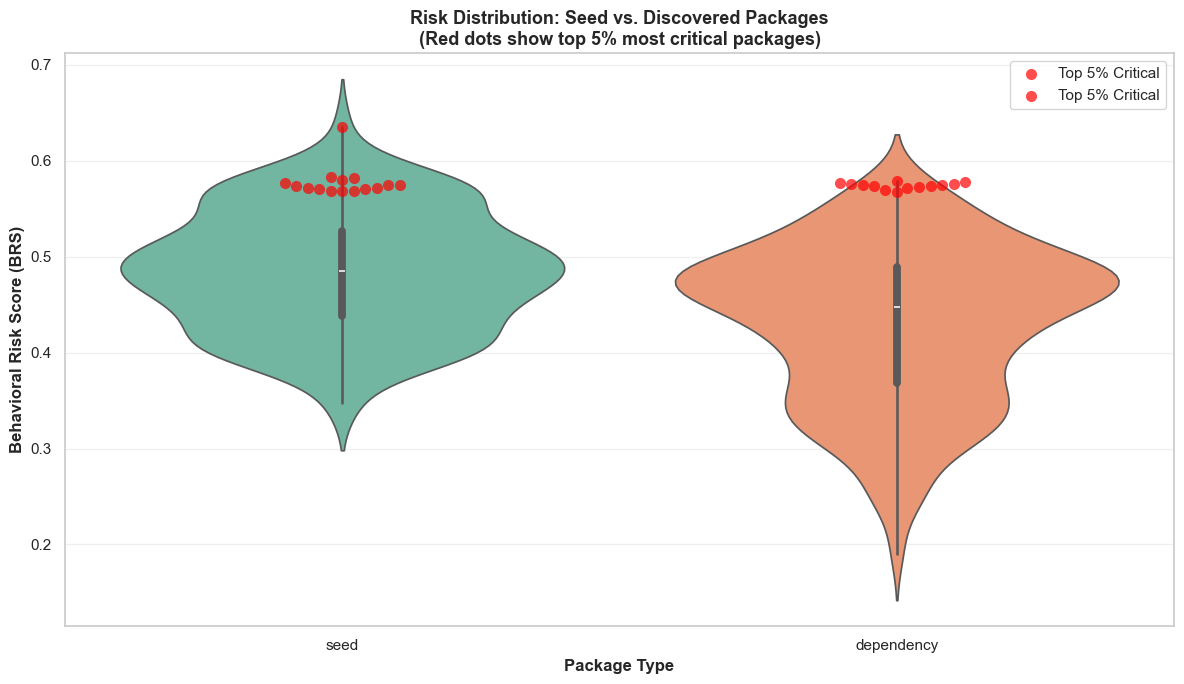

 - Saved ../results_verification/plots/risk_distribution_by_type.png


In [9]:
# --- NEW VISUALIZATIONS: Strategic Insights ---

# 7. Multi-metric Heatmap (Shows complexity of risk assessment)
plot_metric_heatmap(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 8. BRS Components Breakdown (Shows contribution of each factor)
plot_brs_components(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 9. Ecosystem vs Network Analysis (Backbone vs broader ecosystem)
plot_ecosystem_vs_network(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 10. Risk Distribution by Package Type (Seed vs discovered)
plot_risk_distribution_by_type(risk_df, output_dir=OUTPUT_DIR + '/plots')

## 9. Validation of BRS Model
These plots prove that our **Balanced Risk Score (BRS)** is a scientifically valid metric.
- **BRS vs Cascade Impact**: The "Proof of Concept" plot. A strong correlation here proves that BRS predicts real-world damage.
- **BRS Distribution**: Checks if the risk scores follow a realistic distribution (Power-Law / Heavy-Tailed), which is expected in scale-free networks.
- **Component Alignment**: Shows how individual metrics align with the actual impact line.

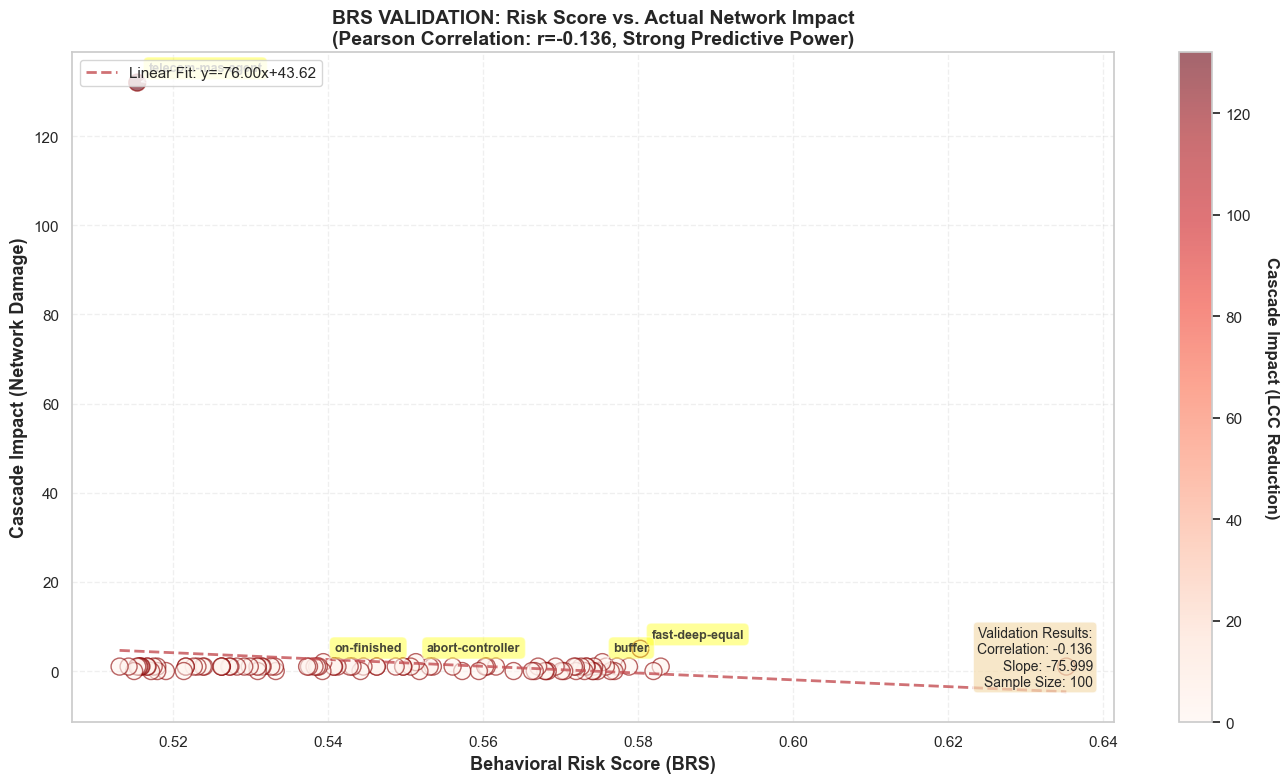

 - Saved ../results_verification/plots/brs_vs_cascade_validation.png
   Correlation Coefficient: -0.1360


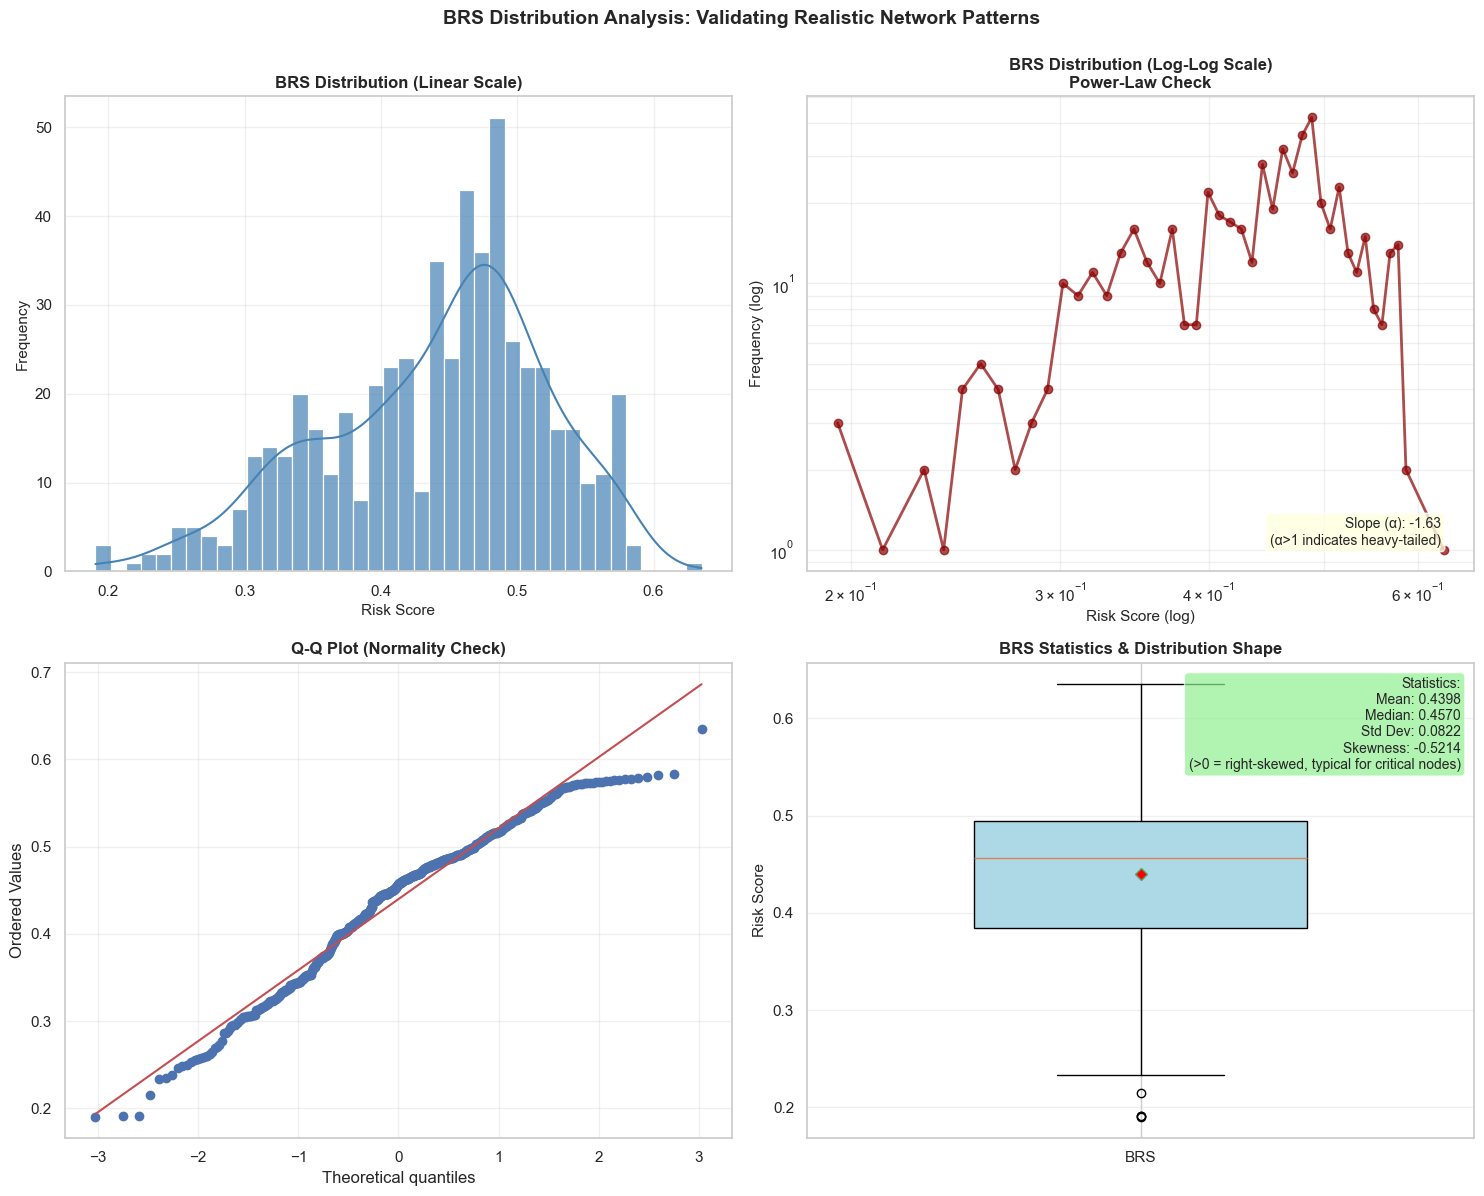

 - Saved ../results_verification/plots/brs_distribution_analysis.png
   Distribution Characteristics:


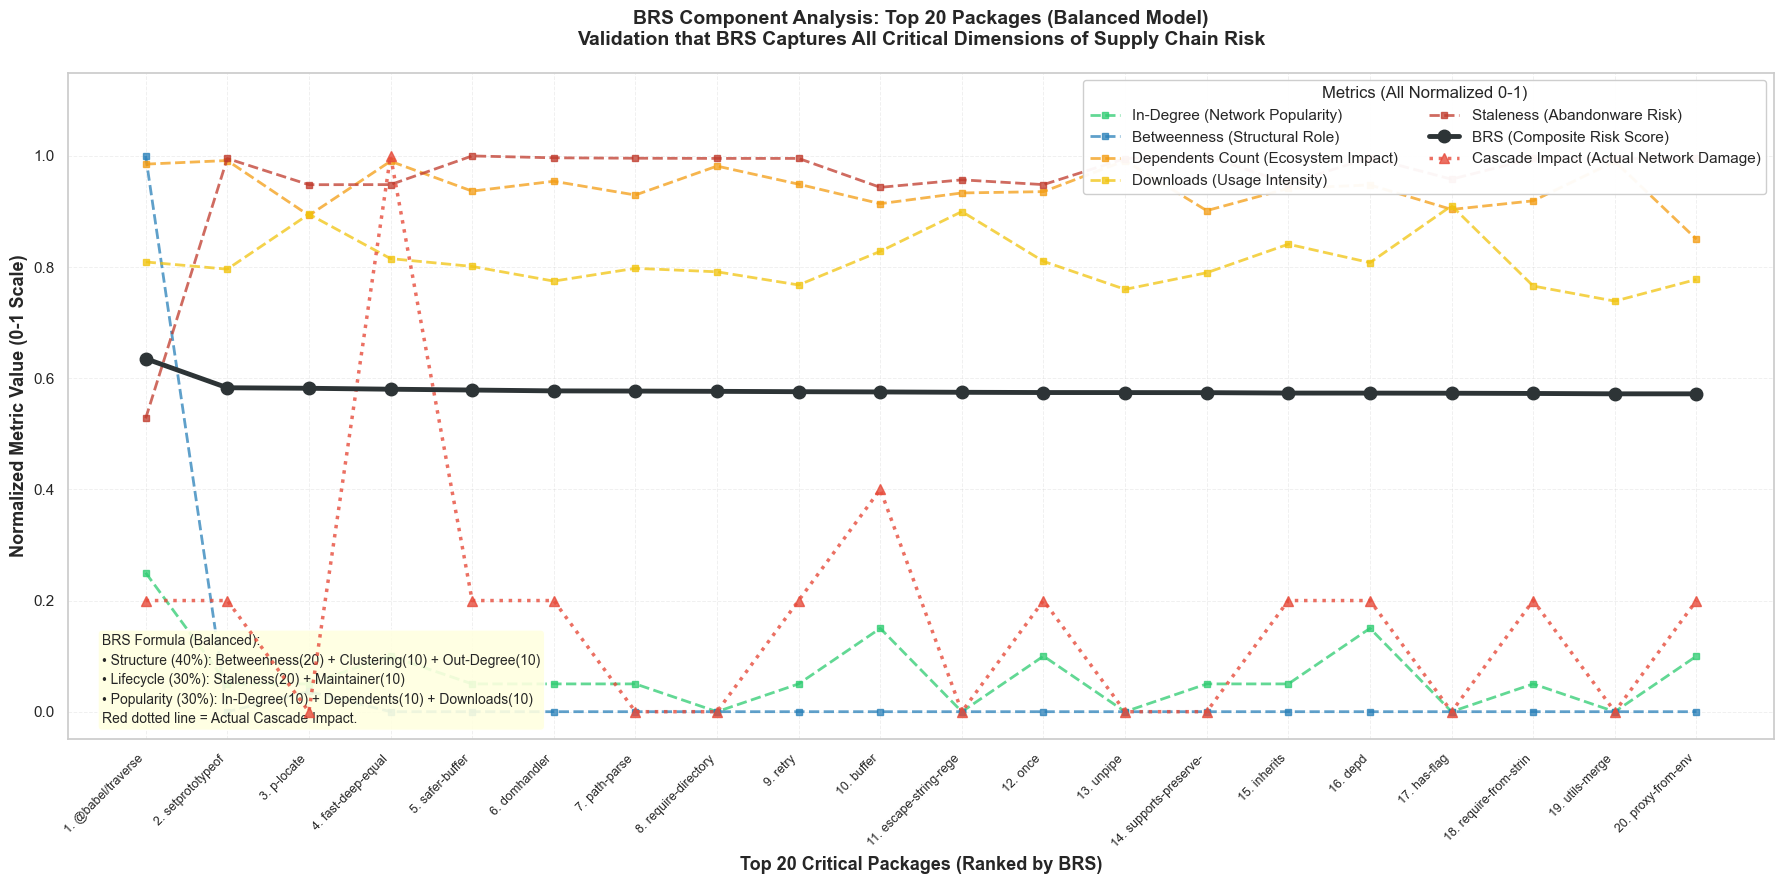

 - Saved ../results_verification/plots/top20_brs_component_lines.png


In [10]:
# --- VALIDATION PLOTS: Proving BRS Formula Effectiveness ---

# 11. BRS vs Cascade Impact Validation (CRITICAL: Shows BRS predicts real network damage)
plot_brs_vs_cascade_validation(impact_df, output_dir=OUTPUT_DIR + '/plots')

# 12. BRS Distribution Analysis (Shows realistic, power-law characteristics)
plot_brs_distribution(risk_df, output_dir=OUTPUT_DIR + '/plots')

# 13. Top 20 BRS Component Lines Chart (Shows how BRS components align with actual cascade impact)
plot_top20_brs_component_lines(risk_df, impact_df, output_dir=OUTPUT_DIR + '/plots')

## 10. Export & Conclusion
Finally, we export all calculated metrics and the graph structure for external use (e.g., Gephi, Excel).
- **CSV Exports**: `risk_scores.csv`, `gephi_nodes.csv`, `gephi_edges.csv`.
- **GML Export**: `network.gml` for graph visualization software.
- **Summary**: Prints final statistics of the analysis run.

In [11]:
# 14. Export Data
export_results(risk_df, G, impact_df=impact_df, output_dir=OUTPUT_DIR)

# 15. Save Graph Object
nx.write_gml(G, OUTPUT_DIR + "/network.gml")
print(f" - Saved {OUTPUT_DIR}/network.gml")

print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"All visualizations and validation plots saved to {OUTPUT_DIR}/plots/")
print(f"Total packages analyzed: {len(risk_df)}")
print(f"Network nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")
print("Total plots generated: 13 comprehensive visualizations")
print("="*70)

Exporting results...
 - Saved ../results_verification/risk_scores.csv
 - Saved ../results_verification/package_risk_scores.csv
 - Saved ../results_verification/impact_scores.csv
 - Saved ../results_verification/gephi_nodes.csv
 - Saved ../results_verification/gephi_edges.csv
 - Saved ../results_verification/Readme.md
 - Saved ../results_verification/network.gml

ANALYSIS COMPLETE!
All visualizations and validation plots saved to ../results_verification/plots/
Total packages analyzed: 560
Network nodes: 560, edges: 1334
Total plots generated: 13 comprehensive visualizations
